# Setting Up Context

In [1]:
# Initialize the spark environment (takes ~ 1min)
import pyspark
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)

In [2]:
data_path = "auto.csv"
df = sqlc.read.format("csv").option("header","true").option("inferSchema", "true").load(data_path)

# Data Prep

## Push Data Into Parquet

In [3]:
parquet_path = 'test-parquet'
df.write.mode("overwrite").parquet(parquet_path)

## Reading Parquet Data

In [4]:
pq_auto = sqlc.read.parquet(parquet_path)
display(pq_auto)

DataFrame[mpg: double, cylinders: int, displacement: double, horsepower: int, weight: decimal(4,0), acceleration: double, year: int, origin: int, name: string]

## Train Test Split

In [5]:
df_test, df_train = df.randomSplit((0.20, 0.80), seed = 369)

## Vectorization
https://towardsdatascience.com/building-a-linear-regression-with-pyspark-and-mllib-d065c3ba246a

In [6]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin'], outputCol = 'features')
df_train = vectorAssembler.transform(df_train)
df_test = vectorAssembler.transform(df_test)
df_train = df_train.select(['features', 'mpg'])
df_test = df_test.select(['features', 'mpg'])


In [7]:
df_test.show(3)

+--------------------+----+
|            features| mpg|
+--------------------+----+
|[8.0,350.0,180.0,...|11.0|
|[8.0,400.0,150.0,...|11.0|
|[8.0,350.0,180.0,...|12.0|
+--------------------+----+
only showing top 3 rows



# MLlib based analysis

In [8]:
from pyspark.ml.regression import LinearRegression, LinearRegressionModel

lr = LinearRegression(featuresCol = 'features', labelCol = 'mpg')
lr_model = lr.fit(df_train)

In [9]:
lr_predictions = lr_model.transform(df_test)
lr_predictions.orderBy(lr_predictions.mpg.desc()).show()

+--------------------+----+------------------+
|            features| mpg|        prediction|
+--------------------+----+------------------+
|[4.0,79.0,58.0,17...|39.1|36.726397493277524|
|[4.0,89.0,60.0,19...|38.1| 34.95945870793514|
|[6.0,262.0,85.0,3...|38.0|28.305390169177983|
|[4.0,105.0,74.0,1...|36.0| 34.50934330098202|
|[4.0,98.0,80.0,19...|35.7|30.881270717356514|
|[4.0,81.0,60.0,17...|35.1|  36.5971106201552|
|[4.0,105.0,63.0,2...|34.7|30.734623246980505|
|[4.0,105.0,74.0,2...|33.0|32.189245611237375|
|[4.0,97.0,67.0,20...|32.3|34.974554784227124|
|[4.0,83.0,61.0,20...|32.0|30.162674311267253|
|[4.0,79.0,67.0,19...|31.0|30.375186172644362|
|[4.0,119.0,82.0,2...|31.0| 28.69656031092903|
|[4.0,76.0,52.0,16...|31.0| 32.20293825945728|
|[4.0,98.0,63.0,20...|30.5|29.028887158321574|
|[4.0,79.0,70.0,20...|30.0|  25.8220382817698|
|[4.0,89.0,62.0,18...|29.8|  33.7817184233167|
|[4.0,97.0,71.0,18...|29.5| 30.56391155451157|
|[4.0,97.0,78.0,19...|29.0| 30.75552378099102|
|[4.0,116.0,9

## Evaluating the Model

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol = 'mpg')
eval.setMetricName("rmse").evaluate(lr_predictions)

3.0451960649740046

In [11]:
# Import numpy, pandas, and ggplot
import numpy as np
from pandas import *

# Create Python DataFrame
cylinders = df_test.rdd.map(lambda p: (p.features[0])).collect()
displacement = df_test.rdd.map(lambda p: (p.features[1])).collect()
horsepower = df_test.rdd.map(lambda p: p.features[2]).collect()
mpg = df_test.rdd.map(lambda p: p.mpg).collect()
pred = lr_predictions.rdd.map(lambda r: r.prediction).collect()

# Create a Pandas DataFrame
pddf = DataFrame({'horsepower' : horsepower, 'mpg' : mpg, 'pred' : pred})

# Create scatter plot and two regression models (scaling exponential) using ggplot
#p = ggplot(pddf, aes('horsepower','mpg')) + \
#  geom_point(color='blue') + \
#  geom_line(pydf, aes('horsepower','pred'), color='red') + \
#  scale_x_log10() + scale_y_log10()
#display(p)

# Creating Visualisations
https://databricks.com/spark/getting-started-with-apache-spark/machine-learning

In [12]:
pddf.set_index('horsepower')

,mpg,pred
horsepower,,
180.0,11.0,16.184086
150.0,11.0,8.840831
180.0,12.0,10.715799
129.0,13.0,20.877167
150.0,13.0,16.595941
170.0,13.0,10.039744
170.0,13.0,8.546201
160.0,14.0,13.969907
165.0,14.0,11.310998


Text(0,0.5,'mpg')

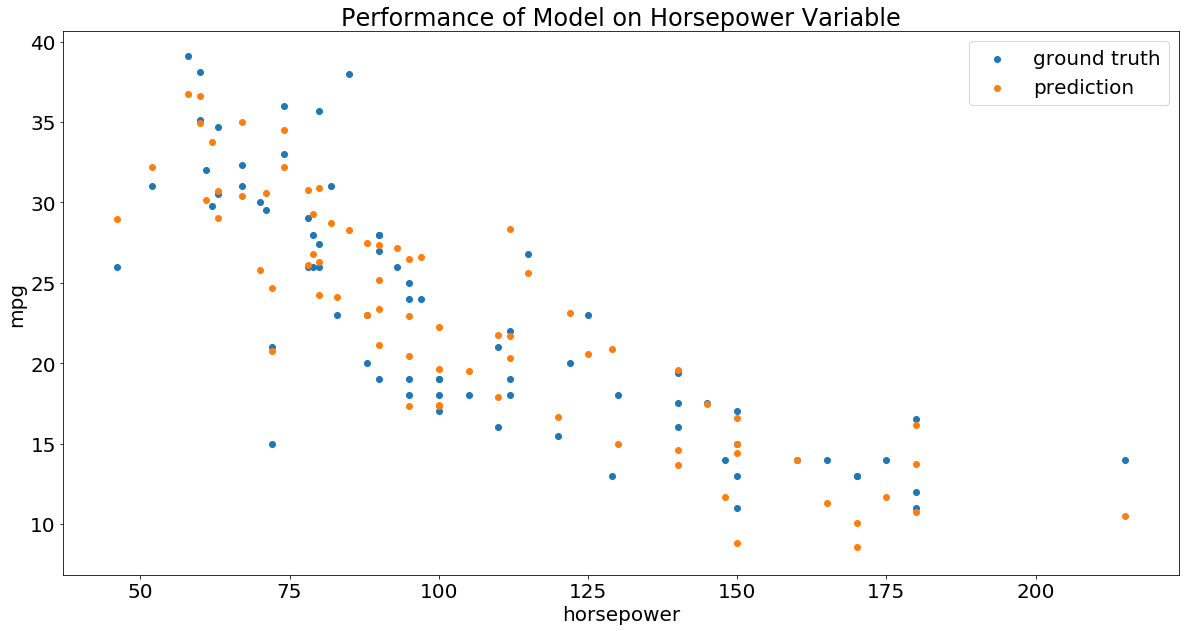

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize = [20, 10])
plt.rcParams.update({'font.size' : 20})
gt = plt.scatter(x = pddf['horsepower'], y = pddf['mpg'])
pd = plt.scatter(x = pddf['horsepower'], y = pddf['pred'])
plt.legend((gt, pd), ('ground truth', 'prediction'))
plt.title("Performance of Model on Horsepower Variable")
plt.xlabel("horsepower")
plt.ylabel("mpg")
